# U.S. Chronic Disease Indicators (CDI)

*"CDC's Division of Population Health provides cross-cutting set of 124 indicators that were developed by consensus and that allows states and territories and large metropolitan areas to uniformly define, collect, and report chronic disease data that are important to public health practice and available for states, territories and large metropolitan areas. In addition to providing access to state-specific indicator data, the CDI web site serves as a gateway to additional information and data resources."* - DATA.GOV

**This notebook aims to validate the hypothesis that the probability of a disease to happen is related to where it happened, the location.**

Data source: https://catalog.data.gov/dataset/u-s-chronic-disease-indicators-cdi

### Load data and Setup

In [24]:
### Working with data ###
import numpy as np
import pandas as pd

### Visualization ###
# plotly
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

### Utils ###
import datetime
import warnings

# File format #
import csv
import json
import xml.etree.ElementTree as ET
warnings.filterwarnings("ignore")

#### Load information

In [25]:
df = pd.read_csv("../input/disease_indicators.csv", sep=',')

In [26]:
df.shape

(519718, 34)

In [27]:
df.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'GeoLocation', 'ResponseID', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1',
       'StratificationCategoryID2', 'StratificationID2',
       'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')

### Prepare Data

In [28]:
df['GeoLocation'].head(2)

0                                        NaN
1    (32.84057112200048, -86.63186076199969)
Name: GeoLocation, dtype: object

In [29]:
df_location = df[(df['GeoLocation'].notnull())]

In [30]:
df_location.shape

(516115, 34)

In [31]:
df_location['GeoLocation'].head(2)

1     (32.84057112200048, -86.63186076199969)
2    (64.84507995700051, -147.72205903599973)
Name: GeoLocation, dtype: object

In [32]:
df_location.describe().T

,count,mean,std,min,25%,50%,75%,max
YearStart,516115.0,2013.141980,1.777299,2001.00,2012.0,2013.0,2015.0,2016.00
YearEnd,516115.0,2013.162592,1.762530,2001.00,2012.0,2013.0,2015.0,2016.00
DataValueAlt,346933.0,648.091041,6872.196680,0.00,18.5,41.0,70.3,701437.00
LowConfidenceLimit,308082.0,46.824561,77.729892,0.20,12.7,30.2,55.4,1330.66
HighConfidenceLimit,308082.0,59.148461,88.962868,0.42,19.0,43.9,70.5,2088.00
LocationID,516115.0,30.797628,17.629397,1.00,17.0,30.0,44.0,78.00


In [33]:
# Convert to float and transform errors in nan
df_location['DataValue'] = pd.to_numeric(df_location['DataValue'], errors='coerce')

#### Get top 10 cities by disease

In [34]:
df_location.shape

(516115, 34)

In [35]:
top_10_cities = (df_location.assign(rank=df_location.groupby(['Topic'])['DataValue']
                     .rank(method='dense', ascending=False))
                     .query('rank <= 10')
                     .sort_values(['Topic', 'rank']))

In [36]:
top_10_cities.rename(columns={'LocationDesc':'city'}, inplace=True)

In [37]:
to_n_ranks_cities = (
    top_10_cities
    .groupby('city')['Topic']
    .nunique()
    .to_frame('Number of times in top 10')
    .reset_index()
    .sort_values(['Number of times in top 10'], ascending=True) # Since the orientation is horizontal, the sort must be the inverse order of what I want
)

### Testing Hypothesis

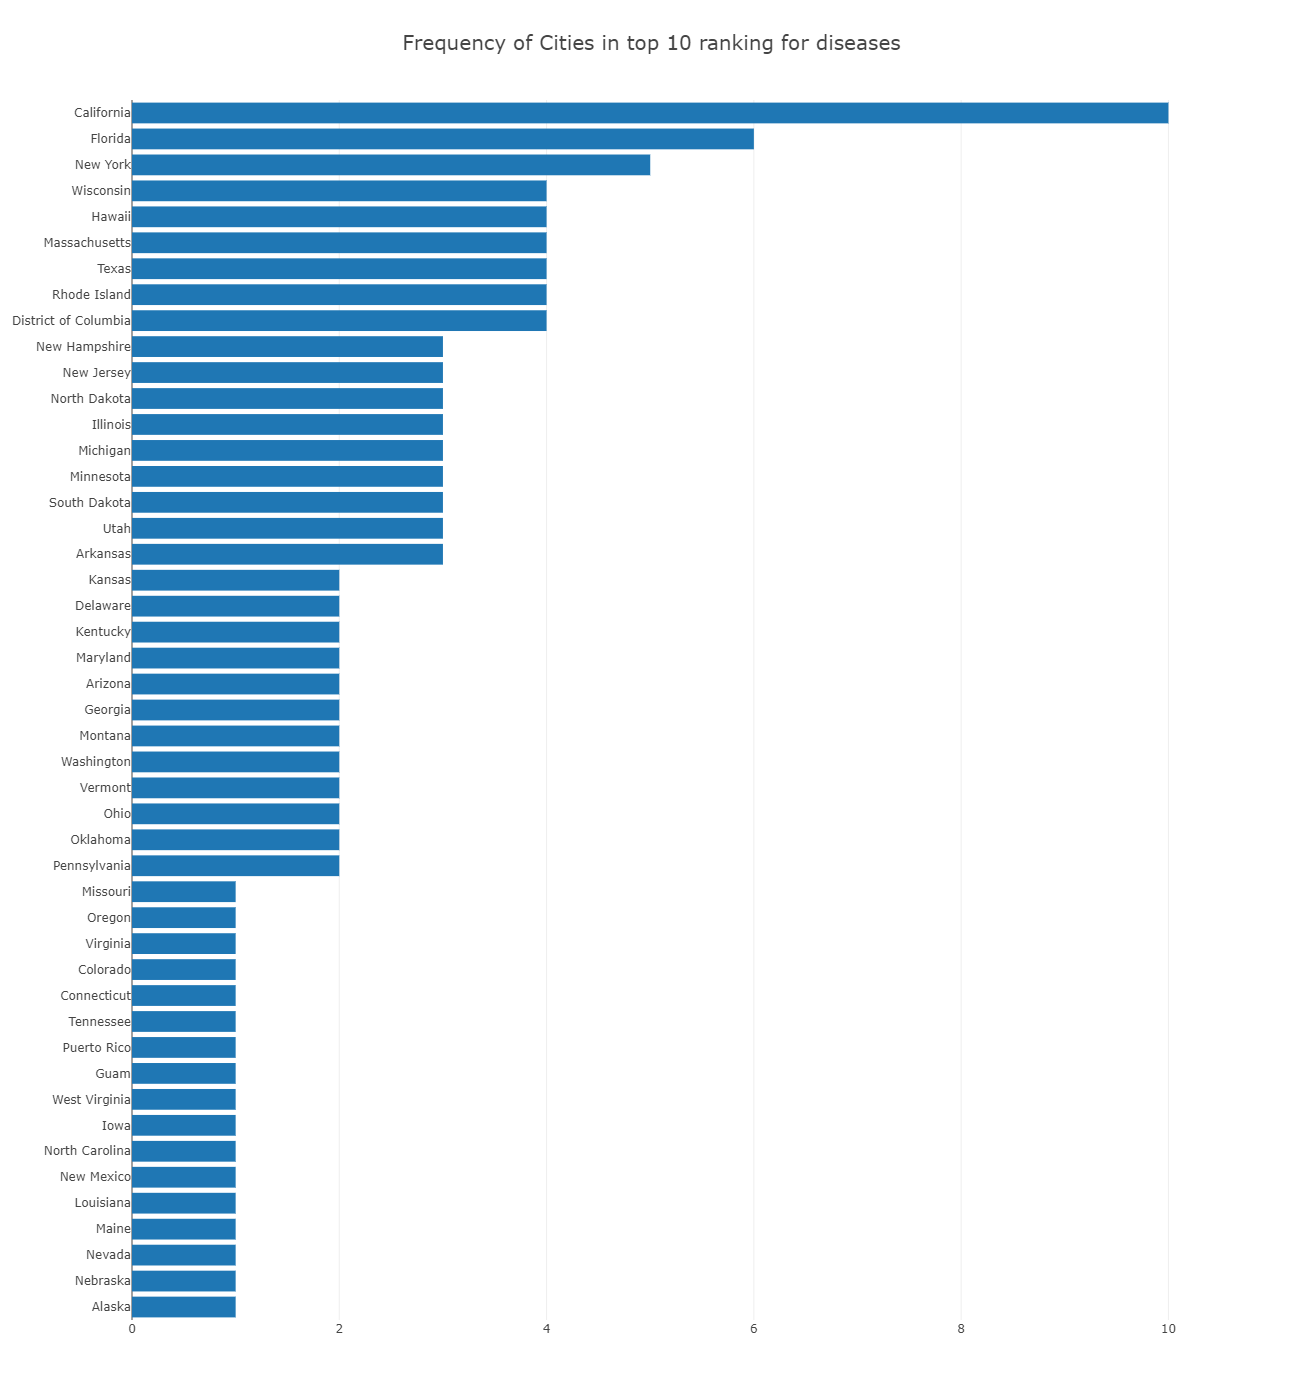

In [38]:
data = [go.Bar(
            y=to_n_ranks_cities['city'],
            x=to_n_ranks_cities['Number of times in top 10'],
            orientation = 'h',
            text=to_n_ranks_cities['Number of times in top 10']
    )]

layout = go.Layout(
    title='Frequency of Cities in top 10 ranking for diseases',
    titlefont=dict(size=20),
    width=1000,
    height=1400,
    yaxis=go.layout.YAxis(
        ticktext=to_n_ranks_cities['city'],
        tickmode='array',
        automargin=True
    )
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

#### Results
As can be seen in the chart above, some cities, specially Arizona, have come up to 10 times in the top 10 ranking cities where a specific disease appeared. Proving our hypothesis that the probability of a disease to happen is correlated to the location.